## Estimate generalization error of Random feature model 

Population error: for each p-value(p=4,6,8,10,12,14,16,18,20), generate batch_size=100 test sets S', take 1000 w, calculate the average MSE.\
Empirical error: error on training set, that is generated (S,w) data for each p-value.\
Generalization error: population error - empirical error.

### data

In [50]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
import os

os.chdir('C://Users//sunji//Documents//WeChat Files//wxid_rjlp06765c5a21//FileStorage//File//2023-10')
os.listdir('data')

['gibbs_data_p_is_10.json',
 'gibbs_data_p_is_12.json',
 'gibbs_data_p_is_14.json',
 'gibbs_data_p_is_16.json',
 'gibbs_data_p_is_18.json',
 'gibbs_data_p_is_20.json',
 'gibbs_data_p_is_4.json',
 'gibbs_data_p_is_6.json',
 'gibbs_data_p_is_8.json']

In [7]:
for p_current in range(4,22,2):
    with open('data/gibbs_data_p_is_{}.json'.format(p_current), 'r') as datafile:
        data = json.load(datafile)
    print(len(data))

50000
50000
50000
100000
100000
100000
100000
150000
150000


### population error

In [8]:
def population_MSE(w_list,p,batch_size=100):
    """ Estimate population error of Random feature model.
    
    :param w_list: list of generated w for estimation 
    :param p: dimension of student model（可变）
    :param batch_size: number of test dataset S'
    :return: float, MSE for population error
    """

    """
    参数设置：与训练所用teacher model保持一致（来自09-29: Gibbs.py）
    """
    original_random_state = np.random.get_state()
    np.random.seed(20230929) 
    #gaussian distribution sampler: normal(mean=0.0, variance_sqrt=1.0, size=None) s = np.random.normal(0,1)
    #teacher model
    #dimension of x: d（固定不变）10->5
    d = 5
    #number of training samples（固定不变）100->20
    N = 20
    #dimension of hypothesis space
    p0 = 5 #dimension of teacher model（固定不变）
    p = p #dimension of student model（可变）#p=200
    p_max = 2000 #upper bound of dimension of student model（固定不变）
    #point-wise activate function f:tanh
    #variance of random noise added to y
    sigma = 0.1

    #random feature matrix
    F0 = np.random.normal(0,1,(d,p0)) #生成teacher model的random feature matrix F0（固定不变）
    F = np.random.normal(0,1,(d,p_max))[:,:p] #生成student model的random feature matrix F(d*p)。先按照p_max的大小生成，再根据当前维度p的不同截取前p列形成每个p对应的F。
        #注意，这个F对于一般的神经网络是可训练的，但是对于RFM为了简化直接设定为固定值。（固定不变）
    #teacher parameter w(p) with lambda = ? until each dim of Y~1e0
    lambda_ = 0.0001
    #w_0 = np.random.normal(0,sigma/np.sqrt(lambda_*N),p)
    w_0 = np.random.normal(0,1,p0) #生成teacher model的权重向量（固定不变）
    #w_0 = np.concatenate((w_0,np.zeros(5)),axis = 0)
    
    np.random.set_state(original_random_state)
    np.random.seed(20231004+p) #每个p用不同的随机种子,对应不同固定随机的测试集
    
    MSE_list=[]
    for w in w_list:
        error_list=[]
        for _ in range(batch_size):
            '''
            采样测试集S'：每次测试集重新生成，此处采样一个S=(X,Y)
                 采样X(N*d)，X经过F0和w_0作用后再加上高斯扰动（这个扰动是必要的，不然构成确定映射不影响互信息）形成Y，
                 Y与X一起构成了从dataset里采样的N个样本，对应了论文中的=>S （可变）
            '''
            #samples X(N*d) 
            X = np.random.normal(0,1,(N,d)) #生成N个d维随机向量，作为N条样本组成的训练集。
            #X after the random feature matrix
            X_rf0 = np.tanh(X.dot(F0)/np.sqrt(d))
            Y_pure = X_rf0.dot(w_0)
            Y = Y_pure + np.random.normal(0,sigma,N) #由X通过teacher model（也就是F0和w_0）生成的Y

            '''
            w预测：X经过F和w_0作用形成pred_Y，泛化误差mse:E[（Y-pred_Y）^2]
            '''
            X_rf = np.tanh(X.dot(F)/np.sqrt(d))
            diff = Y-X_rf.dot(w)
            error_list.append(diff.dot(diff)/N)  #除一个训练集的样本数N
        
        MSE_list.append(sum(error_list)/batch_size)
        
    return sum(MSE_list)/len(MSE_list)

p=4: population error=0.13166503606161856
p=6: population error=0.054328201863135236
p=8: population error=0.05955941398233997
p=10: population error=0.06226306030798395
p=12: population error=0.06343833011048378
p=14: population error=0.06207845045996877
p=16: population error=0.06478604841541427
p=18: population error=0.06449780406424395
p=20: population error=0.06354739073558927


Text(0.5, 1.0, 'Population error (w_num = 1000,test_size = 1000)')

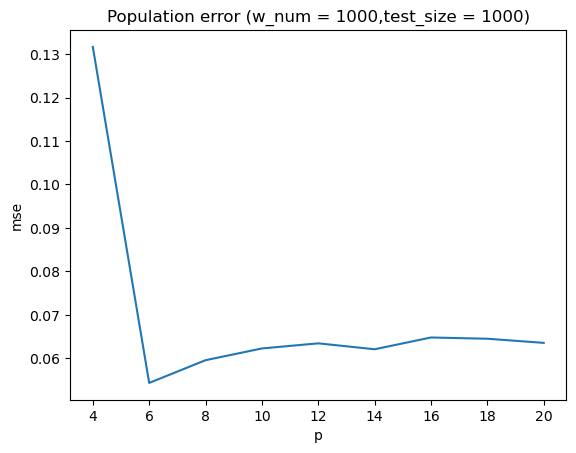

In [59]:
#param
w_num = 1000
test_size = 1000

population_error=[]
for p_current in range(4,22,2):
    with open('data/gibbs_data_p_is_{}.json'.format(p_current), 'r') as datafile:
        data = json.load(datafile)
    w_sample=[dist['w'] for dist in data[:w_num]]

    p_error = population_MSE(w_sample,p_current,test_size)
    population_error.append(p_error)
    print('p={}: population error={}'.format(p_current,p_error))

#plot
plt.plot(range(4,22,2), population_error)
plt.xlabel('p')
plt.ylabel('mse')
plt.title('Population error (w_num = 1000,test_size = 1000)')

### empirical error

In [57]:
def empirical_MSE(data,p):
    """ Culculate empirical error.
    
    :param data: list of generated (S,w), of which each element is a dictionary like {'S':xxx,'w':xxx}
    :param p: dimension of student model（variable）
    :return: float, MSE for empirical error.
    """

    """
    参数设置：与训练所用teacher model保持一致（来自09-29: Gibbs.py）
    """
    original_random_state = np.random.get_state()
    np.random.seed(20230929) 
    #gaussian distribution sampler: normal(mean=0.0, variance_sqrt=1.0, size=None) s = np.random.normal(0,1)
    #teacher model
    #dimension of x: d（固定不变）10->5
    d = 5
    #number of training samples（固定不变）100->20
    N = 20
    #dimension of hypothesis space
    p0 = 5 #dimension of teacher model（固定不变）
    p = p #dimension of student model（可变）#p=200
    p_max = 2000 #upper bound of dimension of student model（固定不变）
    #point-wise activate function f:tanh
    #variance of random noise added to y
    sigma = 0.1

    #random feature matrix
    F0 = np.random.normal(0,1,(d,p0)) #生成teacher model的random feature matrix F0（固定不变）
    F = np.random.normal(0,1,(d,p_max))[:,:p] #生成student model的random feature matrix F(d*p)。先按照p_max的大小生成，再根据当前维度p的不同截取前p列形成每个p对应的F。
        #注意，这个F对于一般的神经网络是可训练的，但是对于RFM为了简化直接设定为固定值。（固定不变）
    #teacher parameter w(p) with lambda = ? until each dim of Y~1e0
    lambda_ = 0.0001
    #w_0 = np.random.normal(0,sigma/np.sqrt(lambda_*N),p)
    w_0 = np.random.normal(0,1,p0) #生成teacher model的权重向量（固定不变）
    #w_0 = np.concatenate((w_0,np.zeros(5)),axis = 0)
    
    np.random.set_state(original_random_state)
    
    
    error_list=[]
    for pair_dict in data:
        X= np.array(pair_dict['S'])[:,:-1]
        Y= np.array(pair_dict['S'])[:,-1]
        w= np.array(pair_dict['w'])
    
        X_rf = np.tanh(X.dot(F)/np.sqrt(d))
        diff = Y-X_rf.dot(w)
        error_list.append(diff.dot(diff)/N)  #除一个训练集的样本数N
            
    return sum(error_list)/len(error_list)

p=4: empirical error=0.0901071611401693
p=6: empirical error=0.029816494666395018
p=8: empirical error=0.028760262307305308
p=10: empirical error=0.026162358751591234
p=12: empirical error=0.02422284673491353
p=14: empirical error=0.022653861715929542
p=16: empirical error=0.02116989580532596
p=18: empirical error=0.019141414750784885
p=20: empirical error=0.016749319260814598


Text(0.5, 1.0, 'Empirical error')

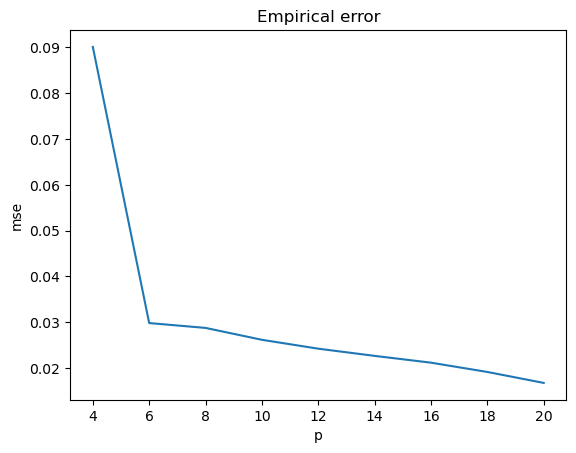

In [58]:
empirical_error=[]
for p_current in range(4,22,2):
    with open('data/gibbs_data_p_is_{}.json'.format(p_current), 'r') as datafile:
        data = json.load(datafile)

    e_error = empirical_MSE(data,p_current)
    empirical_error.append(e_error)
    print('p={}: empirical error={}'.format(p_current,e_error))

#plot
plt.plot(range(4,22,2), empirical_error)
plt.xlabel('p')
plt.ylabel('mse')
plt.title('Empirical error')

### generalization error

In [104]:
np.array(population_error)

array([0.13166504, 0.0543282 , 0.05955941, 0.06226306, 0.06343833,
       0.06207845, 0.06478605, 0.0644978 , 0.06354739])

In [64]:
generalization_error=np.array(population_error) - np.array(empirical_error)
generalization_error

array([0.04155787, 0.02451171, 0.03079915, 0.0361007 , 0.03921548,
       0.03942459, 0.04361615, 0.04535639, 0.04679807])

In [63]:
empirical_error

[0.0901071611401693,
 0.029816494666395018,
 0.028760262307305308,
 0.026162358751591234,
 0.02422284673491353,
 0.022653861715929542,
 0.02116989580532596,
 0.019141414750784885,
 0.016749319260814598]

In [62]:
population_error

[0.13166503606161856,
 0.054328201863135236,
 0.05955941398233997,
 0.06226306030798395,
 0.06343833011048378,
 0.06207845045996877,
 0.06478604841541427,
 0.06449780406424395,
 0.06354739073558927]

In [102]:
import pandas as pd

df = pd.DataFrame([population_error,empirical_error,generalization_error],columns=range(4,22,2))
df.insert(0, 'Risk Type', ['population','empirical','generalization'])
df.to_csv('risk value.csv', index=False)
df

,Risk Type,4,6,8,10,12,14,16,18,20
0,population,0.131665,0.054328,0.059559,0.062263,0.063438,0.062078,0.064786,0.064498,0.063547
1,empirical,0.090107,0.029816,0.028760,0.026162,0.024223,0.022654,0.021170,0.019141,0.016749
2,generalization,0.041558,0.024512,0.030799,0.036101,0.039215,0.039425,0.043616,0.045356,0.046798


### visualization

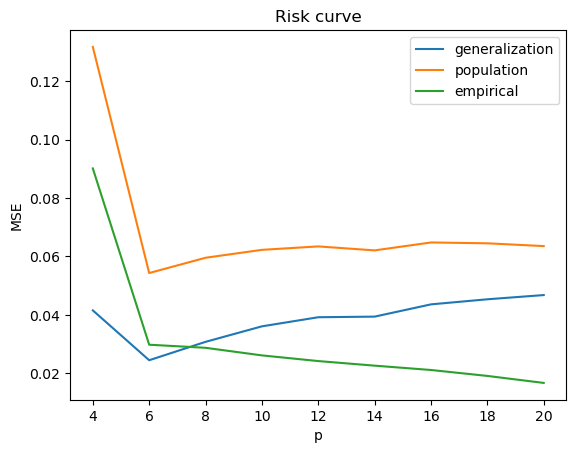

In [96]:
# plt.figure(figsize = (8,4))
x=range(4,22,2)
plt.plot(x, generalization_error,label='generalization')
plt.plot(x, population_error,label='population')
plt.plot(x, empirical_error,label='empirical')

plt.legend()
plt.xlabel('p')
plt.ylabel('MSE')
plt.title('Risk curve')
plt.show()

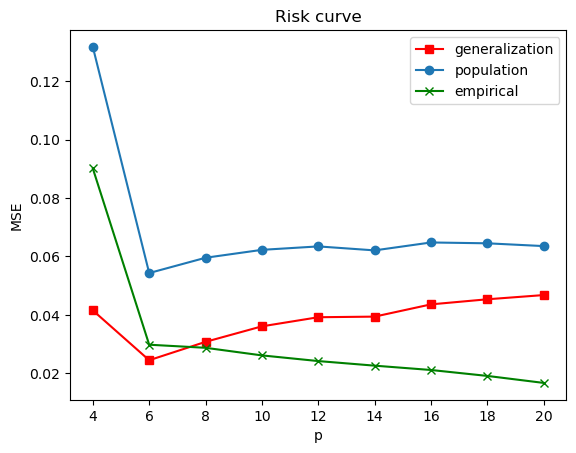

In [94]:
# plt.figure(figsize = (8,4))
x=range(4,22,2)
plt.plot(x, generalization_error,label='generalization',color='r',marker='s')
plt.plot(x, population_error,label='population',marker='o')
plt.plot(x, empirical_error,label='empirical',color='g',marker='x')

plt.legend()
plt.xlabel('p')
plt.ylabel('MSE')
plt.title('Risk curve')
plt.show()

### Tuning hyperparameters

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [11:17<00:00,  4.55s/it]


Text(0.5, 1.0, 'Empirical error vs sample size')

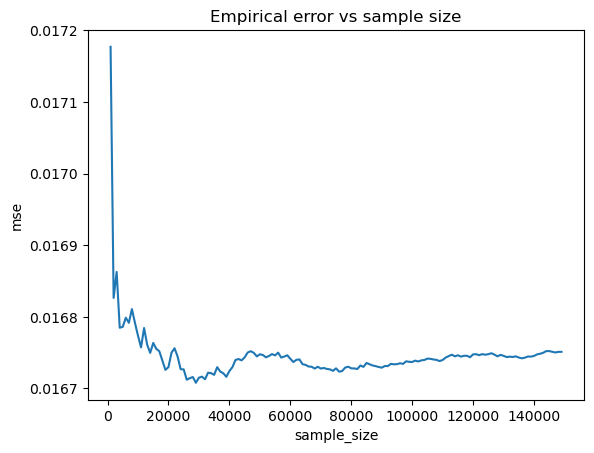

In [103]:
p_current=20
with open('data/gibbs_data_p_is_{}.json'.format(p_current), 'r') as datafile:
    data = json.load(datafile)
    
error_list=[]
for sample_size in tqdm(range(1000,len(data),1000)):
    sample=data[:sample_size]

    error = empirical_MSE(sample,p_current)
    error_list.append(error)
#     print('sample_size={}: empirical error={}'.format(sample_size,error))
    
    
#plot
plt.plot(range(1000,len(data),1000), error_list)
plt.xlabel('sample_size')
plt.ylabel('mse')
plt.title('Empirical error vs sample size')